## Chapter6. 게이트가 추가된 RNN


### 1. RNN의 문제점
- RNN은 시계열 데이터의 장기 의존 관계를 학습하기 어렵다
- 그 원인은 BPTT에서 기울기 소실 혹은 기울기 폭발이 일어나기 때문이다

1.1 RNN 복습

- RNN 계층은 순환 경로를 갖고 있다
- 시계열 데이터인 xt를 입력하면 ht를 출력한다
- 이 ht는 RNN 계층의 은닉상태라고 하여, 과거의 정보를 저장한다
- 이전 시각의 은닉 상태를 이용하여 과거정보를 계승

1.2 기울기 소실 또는 기울기 폭발
- RNN계층이 과거 방향으로 의미 있는 기울기를 전달함으로써 시간 방향의 의존관계를 학습할 수 있다
- 기울기는 학습해야 할 의미가 있는 정보가 들어 있고, 그것을 과거로 전달함으로써 장기 의존 관계를 학습한다
- 하지만 기울기가 중간에 사그라들면 가중치 매개변수는 전혀 갱신되지 않고 장기 의존관계를 학습할 수 없다
- 현재의 단순한 RNN계층에서는 시간을 거슬러 올라갈수록 기울기가 작아지거나(기울기 소실) 혹은 커질 수 있으며(기울기 폭발), 대부분 둘 중 하나의 운명을 걷게 된다

1.3 기울기 소실과 기울기 폭발의 원인
- 역전파로 전해지는 기울기는 차례로 tanh, +, MatMul 연산을 통과한다
- \+ 의 역전파는 상류에서 전해지는 기울기를 그대로 하류로 흘려보낼 뿐 기울기가 변하지는 않는다

$\text{hyperoic} \text{tangent} y=tanh \left(x\right)=\cfrac{e^x-e^{-x}}{e^x+e^{-x}}$  

분수 함수의 미분공식$\{ \cfrac{f(x)}{g(x)} \}^{'} = \cfrac{f'(x)g(x)-f(x)g'(x)}{g(x)^2}$

$\cfrac{\partial e^x}{\partial x}=e^x, \;\; \cfrac{\partial e^{-x}}{\partial x}=-e^{-x} \;\;를\; 이용하여$

$\cfrac{\partial \tanh \left(x\right)}{\partial x}\ =\ \cfrac{\left(e^x+e^{-x}\right)\left(e^x+e^{-x}\right)-\left(e^x-e^{-x}\right)\left(e^x-e^{-x}\right)}{\left(e^x+e^{-x}\right)^2}$

$=1-\cfrac{\left(e^x-e^{-x}\right)^2}{\left(e^x+e^{-x}\right)^2}\ =\ 1-\tanh \left(x\right)^2\ =\ 1-y^2$

- tanh(x)의 미분값은 1.0 이하이고 0에서 멀어질수록 작아진다. 달리 말하면, 역전파에서는 기울기가 tanh 노드를 지날 때마다 값이 계속 작아진다는 뜻이다
- RNN 계층의 활성화 함수로는 주로 tanh 함수를 사용하는데 이를 ReLU로 바꾸면 기울기 소실을 줄일 수 있다
- MatMul 기울기의 크기는 시간에 비례해 지수적으로 증가(기울기 폭팔)하거나 감소(기울기 소실) 한다. 행렬 Wh를 T번 반복해서 곱했기 때문이다

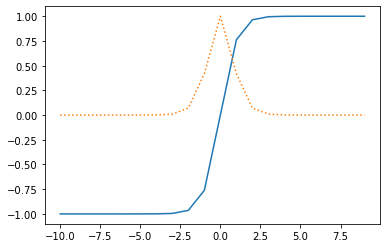

In [7]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-10, 10)
y1 = np.tanh(x)
y2 = 1 - np.tanh(x) ** 2

plt.plot(x, y1)
plt.plot(x, y2, ':')

1.4 기울기 폭발 대책
- 기울기 폭발의 대책으로 전통적인 기울기 클리핑 gradients clipping 기법이 있다
- 신경망에서 사용되는 모든 매개변수에 대한 기울기를 하나로 처리한다고 가정(g-hat)하고 문턱값을 초과하면 두 번째 줄의 수식과 같이 기울기를 수정한다

$if\ \mid \mid \hat{g}\mid \mid \ge threshold:$

$\ \ \ \ \hat{g}\ =\ \cfrac{threshold}{\mid \mid \hat{g}\mid \mid }\hat{g}$

In [8]:
# 기울기 클리핑 구현
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

### 2. 기울기 소실과 LSTM

2.1 LSTM의 인터페이스
- LSTM 계층의 인터페이스에 c(기억 셀, memory cell) 라는 LSTM 전용의 기억메커니즘이 있다
- 기억 셀의 특징은 데이터를 자기 자신으로만(LSTM 계층 내에서만) 주고받는다는 것이다. LSTM 계층 내에서만 완결되고, 다른 계층으로는 출력하지 않는다
- 반면, LSTM의 은닉상태 h는 RNN 계층과 마찬가지로 다른 계층으로 출력

2.2 LSTM 계층 조립하기
- LSTM의 기억 셀 c_t에는 시각 t에서의 LSTM 기억이 과거부터 시각 t까지 모든 정보가 저장
- 필요한 정보를 모두 간직한 이 기억을 바탕으로, 외부 계층과 다음 시각의 LSTM에 은닉 상태 h_t 출력
- 기억 셀 c_t는 3개의 입력(c_t-1, h_t-1, x_t)으로부터 어떤 계산을 수행하여 계산하고 갱신된 c_t에 tanh함수를 적용해 h_t를 계산한다
- LSTM의 게이트는 열기/닫기 뿐 아니라 어느 정도(열림 상태, openness, 0.0~1.0) 열지를 조절
- 열림 상태를 제어를 위해 전용 가중치 매개변수를 이용, 이 가중치 매개변수는 학습 데이터로부터 갱신된다. 게이트의 열림 상태를 구할때는 시그모이드 함수를 사용

2.3 output 게이트
- tanh(c_t)에 게이트를 적용.
- tanh(c_t)의 각 원소에 대해 그것이 다음 시각의 은닉 상태에 얼마나 중요한가를 조정한다.
- 이 게이트는 다음 은닉 상태 h_t의 출력을 담당하는 게이트로 output 게이트 라고 한다
- ouput 게이트의 열림상태는 입력 x_t와 이전 상태 h_t-1로부터 구한다

$o\ =\ \sigma \left(x_tW_x^{^{\left(o\right)}}+h_{t-1}W_h^{^{\left(o\right)}}+b^{^{\left(o\right)}}\right)\ \ \ \ \ \ ,\ \sigma \ :\ sigmoid\ function$

- 위의 식에서 구한 출력 o와 tanh(c_t)의 원소별 곱을 h_t로 출력
- o와 tanh(c_t)의 원소별 곱을 아다마르 곱 Hadamard product 이라고 하며 기호로는 ⊙로 나타낸다

2.4 forget 게이트
- 다음으로 할 일은 기억 셀에서 무엇을 잊을까를 명확하게 지시하는 것이다
- forget 게이트 추가하여 게이트의 출력 f를 구하고 이전 기억셀인 c_t-1과 원소별 곱을 구한다

$f\ =\ \sigma \left(x_tW_x^{^{\left(f\right)}}+h_{t-1}W_h^{^{\left(f\right)}}+b^{^{\left(f\right)}}\right)$

2.5 새로운 기억 셀
- forget 게이트를 거치면서 이전 시각의 기억 셀로부터 잊어야 할 기억이 삭제
- 새로 기억해야 할 정보를 기억 셀에 추가(tanh 노드 추가)
- tanh노드가 계산한 결과가 이전 시각의 기억 셀 c_t-1에 더해져 새로운 정보를 추가하여 새로운 기억 생성

$g\ =\ \tanh \left(x_tW_x^{^{\left(g\right)}}+h_{t-1}W_h^{^{\left(g\right)}}+b^{^{\left(g\right)}}\right)$

2.6 input 게이트
- 새로운 기억 셀 g에 input 게이트를 추가
- input 게이트는 g의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지를 판단

$i\ =\ \sigma \left(x_tW_x^{^{\left(i\right)}}+h_{t-1}W_h^{^{\left(i\right)}}+b^{^{\left(i\right)}}\right)$

2.7 LSTM의 기울기 흐름
- LSTM의 구조가 어떤 원리로 기울기 소실을 없애줄까?
- LSTM의 역전파에서는 행렬 곱이 아닌 원소별 곱이 이뤄지고, 매 시각 다른 게이트 값을 이용해 원소별 곱을 계산한다.
- 이처럼 새로운 게이트 값을 이용하므로 곱셈의 효과가 누적되지 않아 기울기 소실이 일어나지 않는다
- 곱하기 노드의 계산은 forget 게이트가 제어. 
- 잊어야 한다고 판단한 기억 셀의 원소에 대해서는 그 기울기가 작아지고 기억해야 한다고 판단한 원소에 대해서는 그 기울기가 약화되지 않은 채로 과거 방향으로 전해진다
- 따라서 기억 셀이 장기 의존 관계를 유지(학습)하리라 기대할 수 있다

### 3. LSTM 구현
- 아핀 변환 affine transformation : 행렬 변환과 평행 이동(편향)을 결합한 형태(xW+hW+b)의 식을 말한다
- LSTM 수행 계산에서 f, g, i, o 네 수식에 포함된 아핀변환을 보면, 네 수식에서 아핀 변환을 개별적으로 수행하지만, 이를 하나의 식으로 정리해 계산할 수 있다

$f=\sigma \left(x_tW_x^{^{\left(f\right)}}+h_{t-1}W_h^{^{\left(f\right)}}+b^{^{\left(f\right)}}\right)\ \ \ \ ,\ \ \ \ g=\tanh \left(x_tW_x^{^{\left(g\right)}}+h_{t-1}W_h^{^{\left(g\right)}}+b^{^{\left(g\right)}}\right)$

$i=\sigma \left(x_tW_x^{^{\left(i\right)}}+h_{t-1}W_h^{^{\left(i\right)}}+b^{^{\left(i\right)}}\right)\ \ \ \ \ \ \ \ ,\ \ \ \ o=\sigma \left(x_tW_x^{^{\left(o\right)}}+h_{t-1}W_h^{^{\left(o\right)}}+b^{^{\left(o\right)}}\right)$

$\Rightarrow \ x_t\ \left[W_x^{^{\left(f\right)}}\ W_x^{^{\left(g\right)}}\ W_x^{^{\left(i\right)}}\ W_x^{^{\left(o\right)}}\right]\ +\ h_{t-1\ }\ \left[W_x^{^{\left(f\right)}}\ W_x^{^{\left(g\right)}}\ W_x^{^{\left(i\right)}}\ W_x^{^{\left(o\right)}}\right]\ +\ \left[b^{^{\left(f\right)}}\ b^{^{\left(g\right)}}\ \ b^{^{\left(i\right)}}\ b^{^{\left(o\right)}}\right]$

$c_t=f\ \odot \ c_{t-1}+g\ \odot \ i\ \ \ \ ,\ \ \ \ h_t=o\ \odot \ \tanh \left(c_t\right)$

- 4개의 가중치(또는 편향)를 하나로 모을 수 있고, 개별적으로 총 4번 수행하던 아핀 변환을 단 1회의 계산으로 끝낼수 있어 계산속도가 빨라진다
- slice 는 아핀 변환의 결과(행렬)를 균등하게 네조각으로 꺼내주는 단순한 노드
- slice 노드 다음에는 활성화 함수(sigmoid or tanh)를 거쳐 계산을 수행

In [9]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''
        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향 (4개분의 편향이 담겨 있음）  
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b

        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

3.1 Time LSTM 구현
- T개분의 시계열 데이터를 한꺼번에 처리하는 계층
- Truncated BPTT는 역전파의 연결은 적당한 길이로 끊고 순전파의 흐름은 그대로 유지

In [10]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layers = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            self.dh = dh
            return dxs
        
    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

### 4. LSTM을 사용한 언어 모델

In [11]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch06')
from common.time_layers import *
import pickle

class Rnnlm:
    def __init__(self, vocab_size=10000, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, r * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, v) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_w, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)

    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

Done
| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10001.60
| 에폭 1 |  반복 21 / 1327 | 시간 6[s] | 퍼플렉서티 2597.52
| 에폭 1 |  반복 41 / 1327 | 시간 13[s] | 퍼플렉서티 1208.02
| 에폭 1 |  반복 61 / 1327 | 시간 20[s] | 퍼플렉서티 954.23
| 에폭 1 |  반복 81 / 1327 | 시간 25[s] | 퍼플렉서티 787.24
| 에폭 1 |  반복 101 / 1327 | 시간 31[s] | 퍼플렉서티 665.38
| 에폭 1 |  반복 121 / 1327 | 시간 37[s] | 퍼플렉서티 649.84
| 에폭 1 |  반복 141 / 1327 | 시간 43[s] | 퍼플렉서티 603.59
| 에폭 1 |  반복 161 / 1327 | 시간 48[s] | 퍼플렉서티 579.12
| 에폭 1 |  반복 181 / 1327 | 시간 54[s] | 퍼플렉서티 590.51
| 에폭 1 |  반복 201 / 1327 | 시간 60[s] | 퍼플렉서티 508.63
| 에폭 1 |  반복 221 / 1327 | 시간 67[s] | 퍼플렉서티 490.85
| 에폭 1 |  반복 241 / 1327 | 시간 74[s] | 퍼플렉서티 445.84
| 에폭 1 |  반복 261 / 1327 | 시간 80[s] | 퍼플렉서티 467.78
| 에폭 1 |  반복 281 / 1327 | 시간 87[s] | 퍼플렉서티 451.76
| 에폭 1 |  반복 301 / 1327 | 시간 93[s] | 퍼플렉서티 395.04
| 에폭 1 |  반복 321 / 1327 | 시간 97[s] | 퍼플렉서티 342.84
| 에폭 1 |  반복 341 / 1327 | 시간 101[s] | 퍼플렉서티 398.12
| 에폭 1 |  반복 361 / 1327 | 시간 104[s] | 퍼플렉서티 410.71
| 에폭 1 |  반복 381 / 1327 | 시간 108[s] | 퍼플렉서티 328

c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 54140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 54540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 47113 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\GIGABYTE\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49

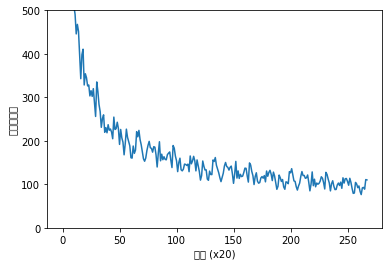

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  135.52704822629613


: 

In [13]:
# PTB 데이터셋 학습
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch06')
from common.optimizer import SGD
from common.trainer import  RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

### 5. RNNLM 추가개선

5.1 LSTM 계층 다양화
- RNNLM으로 정확한 모델을 만들고자 한다면 많은 경우 LSTM 계층을 깊게 쌓아 효과를 볼 수 있다
- 층이 여려겹 쌓일 수록 언어 모델의 정확도가 향상되고 더 복잡한 패턴을 학습할 수 있게 된다
- 몇 층을 쌓아야 할까? 하이퍼파라미터는 처리할 데이터의 복잡도나 학습 데이터 양에 따라 적절히 결정

5.2 드롭아웃에 의한 과적합 억제
- 층을 깊게 쌓음으로써 표현력이 풍부한 모델을 만들 수 있으나 종종 과적합을 일으킨다
- RNN은 일반적인 피드포워드 신경망보다 쉽게 과적합을 일으켜 대책이 중요하고 현재도 활발하게 연구되는 주제
- 과적합을 억제하는 전통적인 방법은 훈련 데이터의 양 늘리기와 모델의 복잡도 줄이기, 복잡도에 페널티를 주는 정규화, 드롭아웃처럼 훈련 시 계층 내의 뉴런 몇 개를 무작위로 무시하고 학습하는 방법 등
- 드롭아웃 dropout은 무작위로 뉴런을 선택하여 선택한 뉴런을 무시(신호 전달을 막는다). 무작위 무시가 제약이 되어 신경망의 일반화 성능을 개선
- RNN에서 시계열 방향으로 드롭아웃을 넣으버리면 흐르는 시간에 비례해 드롭아웃에 의한 노이즈가 축적되어 정보가 사라질 수 있다
- 일반적인 드롭아웃은 깊이 방향으로 삽입하여 시간 방향으로 아무리 진행해도 정보를 잃지 않는다
- 변형 드롭아웃은 깊이 방향은 물론 시간 방향에도 이용할 수 있어서 정확도를 향상
- 같은 계층의 드롭아웃끼리 마스크를 공유함으로써 마스크가 고정되며 정보를 잃게 되는 방법도 고정되므로 정보의 지수적 손실을 예방

5.3 가중치 공유 weight tying
- 계층이 가중치를 공유함으로써 학습하는 매개변수 수가 크게 줄어드는 동시에 정확도도 향상되는 기술
- Embedding 계층과 Affine 계층이 가중치를 연결(공유) 할경우 가중치 구현 관점에서 살펴보면
- 어휘수를 V LSTM의 은닉 차원이 H라 할때 Embedding 계층의 가중치는 형상이 V x H 이며
- Affine 계층의 가중치 형상은 H x V가 된다. Embedding 계층의 가중치를 전치하여 Affine 계층의 가중치로 설정하기만 하면 된다

5.4 개선된 RNNLM 구현
- LSTM 계층의 다층화
- 드롭아웃 사용(깊이방향)
- 가중치 공유

In [1]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch06')
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordbec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(D, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 세가지 개선
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b) # 가중치 공유
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()          

In [ ]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch06')
from common import config
# GPU 실행시 아래 주석 해제(쿠파이 필요)
# ====================================
# config.GPU = True
# ====================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from better_rnnlm import BetterRnnlm

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size, time_size=time_size, max_grad=max_grad)
    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티 : ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-'*50)

In [ ]:
import sys
sys.path.append('D:/Python/14.밑바닥부터시작하는딥러닝/2/ch06')
from common import config
# GPU 실행시 아래 주석 해제(쿠파이 필요)
# ====================================
config.GPU = True
# ====================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from better_rnnlm import BetterRnnlm

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size, time_size=time_size, max_grad=max_grad)
    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티 : ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-'*50)

### 6. 정리
- 단순한 RNN의 학습에서는 기울기 소실과 기울기 폭발이 문제가 된다
- 기울기 폭발에는 기울기 클리핑, 기울기 소실에는 게이트가 추가된 RNN(LSTM과 GRU 등)이 효과적이다
- LSTM에는 input 게이트, forget 게이트, output 게이트 3개의 게이트가 있다
- 게이트에는 전용 가중치가 있으며, 시그모이드 함수를 사용하여 0.0~1.0 사이의 실수를 출력한다
- 언어 모델 개선에는 LSTM 계층 다층화, 드롭아웃, 가중치 공유 등의 기법이 효과적이다
- RNN의 정규화는 중요한 주제이며, 드롭아웃 기반의 다양한 기법이 제안되고 있다